#Classificaçaõ de Cancer de Mama

In [ ]:
import numpy as np #importando a bib numpy para manipular arrays
import pandas as pd #imporando a bib panda para armazenar os dados
%matplotlib inline
from matplotlib import pyplot as plt #importando a bib matplotlib para visualizar os dados em gráficos

#Definindo os nomes dos atributos de cada caso de cancer
cols = ['id', 'Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape', 'Marginal_Adhesion' , 'Single_Epithelial_Cell_Size' , 'Bare_Nuclei' , 'Bland_Chromatin' , 'Normal_Nucleoli', 'Mitoses', 'class']

#Obtendo os dados da iris no repositorio da UCI:
df = pd.read_csv('https://raw.githubusercontent.com/PedroOSilv/BreastCancerClassification/main/breast-cancer-wisconsin.data',names=cols)

#Visualizando o cabeçalho do dataset
df.head()

,id,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


# Pré processamento dos dados

In [ ]:
from sklearn.impute import KNNImputer #importanto o método de imputação do scikit-learn, K-vizinhos
data = df.to_numpy()
#econtrando valores ausentes e colocando em um formato numpy
data[data == '?'] = np.nan

#criando o modelo de imputação k-vizinhos
imputer = KNNImputer(n_neighbors=3)

#fazendo a imputação
data = imputer.fit_transform(data)

for i in range(len(data)):
  if data[i][-1] == 2:
    data[i][-1] = False
  else:
    data[i][-1] = True

#Dividindo o dataset em treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

X = data[:,1:9].astype(float)
y = data[:,-1]

#test_size = 0.2 significa 20% dos dados para teste e 80% para treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
#Vamos pegar uma pocrção do treino para validar nosso modelo durante o treino (20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2)
print('Treino:',X_train.shape)
print('Treino Rotulos:',np.unique(y_train))
print('Validação:',X_val.shape)
print('Validação Rotulos:',np.unique(y_val))
print('Teste:',X_test.shape)
print('Teste Rotulos:',np.unique(y_test))

Treino: (447, 8)
Treino Rotulos: [0. 1.]
Validação: (112, 8)
Validação Rotulos: [0. 1.]
Teste: (140, 8)
Teste Rotulos: [0. 1.]


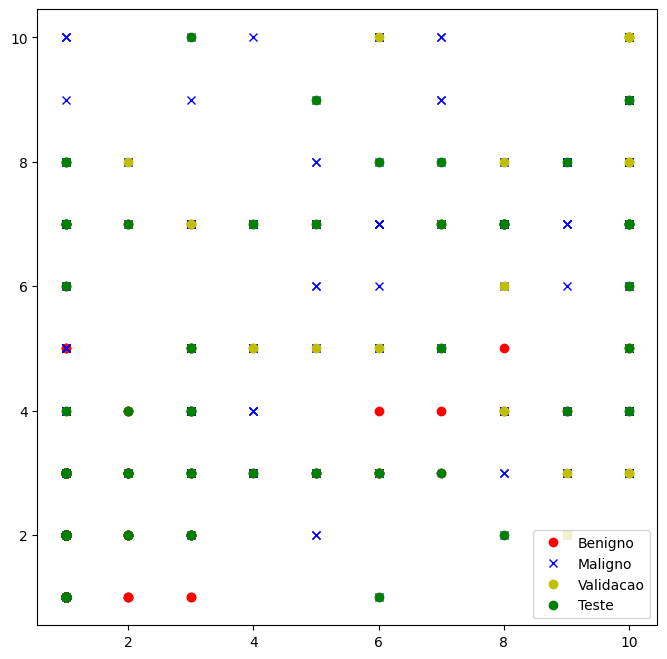

In [ ]:
#Visualizando todos dados por classe (maligno ou benigno) usando 2 dimensões (2 atributos)

benigno= y==0
benigno=X[benigno,:].copy()

maligno= y==1
maligno= X[maligno,:].copy()

a1 = 7
a2 = 6
plt.figure(figsize=(8,8))
plt.plot(benigno[:,a1],benigno[:,a2],'or',label='Benigno')
plt.plot(maligno[:,a1],maligno[:,a2],'xb',label='Maligno')


plt.plot(X_val[:,a1],X_val[:,a2],'yo',label='Validacao')
plt.plot(X_test[:,a1],X_test[:,a2],'go',label='Teste')
plt.legend()

plt.show()

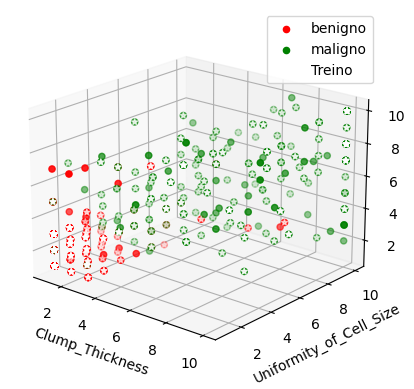

In [ ]:
#Visualizando os dados em 3 dimensoes (Atributos 1,2 e 3)
att1 = 1
att2 = 2
att3 = 6

legendList = ['Clump_Thickness', 'Uniformity_of_Cell_Size', 'Uniformity_of_Cell_Shape', 'Marginal_Adhesion' , 'Single_Epithelial_Cell_Size' , 'Bare_Nuclei' , 'Bland_Chromatin' , 'Normal_Nucleoli', 'Mitoses', 'class']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(20, -50) #Modificando o segundo paramatro rotaciona para esquerda ou direita
ax.scatter(benigno[:,att1],benigno[:,att2],benigno[:,att3],c='r',label = 'benigno')
ax.scatter(maligno[:,att1],maligno[:,att2],maligno[:,att3],c='g',label = 'maligno')

ax.scatter(X_train[:,att1],X_train[:,att2],X_train[:,att3],c='w',marker='*',label = 'Treino')# Dados de treino em branco

ax.set_xlabel(legendList[att1-1])
ax.set_ylabel(legendList[att2-1])
ax.set_zlabel(legendList[att3-1])

plt.legend()
plt.show()

# Configurando a Rede Neural utilizando a biblioteca PYTORCH

In [ ]:
#importando as bibliotecas
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

In [ ]:
#Definindo a arquitetura do modelo
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim): #Definindo as componentes
        super(MLP, self).__init__()
        self.layerEntry = nn.Linear(input_dim, 9)
        self.layerHidden1 = nn.Linear(9, 8)
        self.layerHidden2 = nn.Linear(8, 7)
        self.layerHidden3 = nn.Linear(7, 6)
        self.layerHidden4 = nn.Linear(6, 5)
        self.layerHidden5 = nn.Linear(5, 4)
        self.layerHidden6 = nn.Linear(4, 3)
        self.layerOut = nn.Linear(3, output_dim)

    def forward(self, x): #Definindo a sequencia de execução das componentes
        x = F.leaky_relu(self.layerEntry(x)) #função de ativação F.RELU ou F.sigmoid, ...
        x = F.leaky_relu(self.layerHidden1(x))
        x = F.leaky_relu(self.layerHidden2(x))
        x = F.leaky_relu(self.layerHidden3(x))
        x = F.leaky_relu(self.layerHidden4(x))
        x = F.leaky_relu(self.layerHidden5(x))
        x = F.leaky_relu(self.layerHidden6(x))
        x = F.softmax(self.layerOut(x), dim=1)
        return x

> [Otimizadores](https://pytorch.org/docs/stable/optim.html?highlight=optimizer#torch.optim.Optimizer):  Para calcular o gradiente e atualizar os pesos da rede

> Funções de Erro [(Loss Function)](https://pytorch.org/docs/stable/nn.functional.html?highlight=loss+function):  Para calcuar o erro da rede MLP

In [ ]:
#Criando o modelo
num_atributes = X_train.shape[1] #Número de objetos no conjunto de treino
num_classes = len(np.unique(y_train)) #Número de classes do conjunto de Treinamento (E SE A AMOSTRAGREM DO TREINO NÃO TEM TODAS AS CLASSES? DA RUIM!)
print(num_classes)
#Criando o Modelo
model= MLP(num_atributes,num_classes)

#Método para calcular o GRADIENTE e ATUALIZAR pesos (otimizadores)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

#Funções de Erro:
loss_fn   = nn.CrossEntropyLoss() #Entropia Cruzada

2


In [ ]:
from sklearn import preprocessing

#Criando a estrutura de dados para o PYTORCH (Variable -> Tensor)
X_trainT = Variable(torch.from_numpy(X_train)).float()
y_trainT = preprocessing.LabelEncoder().fit_transform(y_train)
y_trainT = Variable(torch.from_numpy(y_trainT)).long()

X_valT = Variable(torch.from_numpy(X_val)).float()
y_valT = preprocessing.LabelEncoder().fit_transform(y_val)
y_valT = Variable(torch.from_numpy(y_valT)).long()

X_testT  = Variable(torch.from_numpy(X_test)).float()
y_testT = preprocessing.LabelEncoder().fit_transform(y_test)
y_testT  = Variable(torch.from_numpy(y_testT)).long()


# Configurando o Uso da GPU

In [ ]:
import torch
import torch.cuda as cuda

# Definir o dispositivo que irá executar
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device\n")
model.to(device)    # Convert model parameters and buffers to CPU or Cuda

# Function to save the model
def saveModel():
    path = "./NetModel.pth"
    torch.save(model.state_dict(), path)

X_trainT = X_trainT.to(device)
y_trainT = y_trainT.to(device)

X_valT = X_valT.to(device)
y_valT = y_valT.to(device)

X_testT = X_testT.to(device)
y_testT = y_testT.to(device)


The model will be running on cuda device



#Treinando o Modelo

In [ ]:
#Treinamento do Modelo
from sklearn import preprocessing
import tqdm

EPOCHS  = 50000
min_loss = 100000
best_epoch = -1

loss_train   = np.zeros((EPOCHS,))
loss_val     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_trainT)
    loss = loss_fn(y_pred, y_trainT)
    loss_train[epoch] = loss.item()

    optimizer.zero_grad()# Zerando os valores de Gradiente para não serem considerados da época anterior
    loss.backward() # Calculando o Gradiente
    optimizer.step() #Atualizando os paramentros da rede

    with torch.no_grad():
        y_pred = model(X_valT)
        loss = loss_fn(y_pred, y_valT)
        loss_val[epoch] = loss.item()
        if loss_val[epoch] < min_loss:
          best_epoch = epoch
          min_loss = loss_val[epoch]
        correct = (torch.argmax(y_pred, dim=1) == y_valT).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

print('\nMenor erro da Validação: ',min_loss,' EPOCA ',best_epoch)

100%|██████████| 50000/50000 [02:04<00:00, 402.45it/s]


Menor erro da Validação:  0.34446293115615845  EPOCA  9059


## Como foi o treinamento, teve Overfitting?
>Observando as curvas de erro da validação e do treino observamos que o erro do treinamento foi caindo ao longo do tempo e ao mesmo tempo a curva de erro da validação seguiu o mesmo comportamento. Nesse cenário, não foi identificado overffiting (caso em que a curva de erro da validação começa a subir)

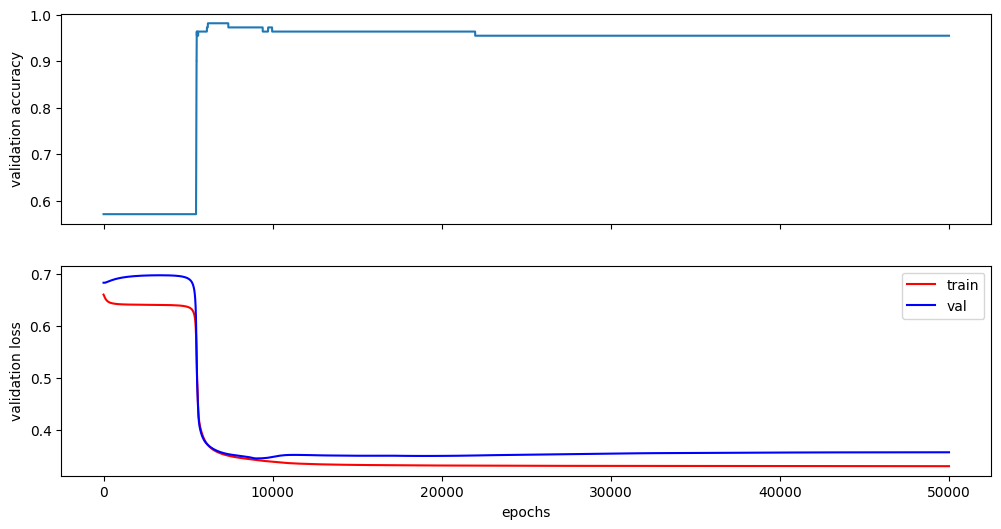

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_train,'-r',label='train')
ax2.plot(loss_val,'-b',label='val')
ax2.set_ylabel("validation loss")
ax2.set_xlabel("epochs");
ax2.legend()

>Salvando o modelo treinado

In [ ]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_val,}, 'myMLP.tar')

#Testando o modelo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with torch.no_grad():
    y_pred = model(X_testT) #Passando os dados para o modelo treinado
    print('resultados da predição:\n',y_pred[:5,:])
    print('melhores resultados (MAX) de cada predição: ',torch.argmax(y_pred, dim=1)[:5])
    print('Resultados da anotação do conjunto de teste: ',y_testT[:5])
    rigth_wrong_ans = (torch.argmax(y_pred, dim=1) == y_testT) #Vericando quais repostas casam com a anotação
    correct = (rigth_wrong_ans).type(torch.FloatTensor) #Convertendo False=0.0 True=1.0
    acc = correct.mean() #Calculando a media de valores (1.0, i.e. corretos)
    print('Acertos :',acc)

resultados da predição:
 tensor([[1.6792e-05, 9.9998e-01],
        [5.2142e-12, 1.0000e+00],
        [9.9837e-01, 1.6300e-03],
        [9.9837e-01, 1.6298e-03],
        [9.9837e-01, 1.6299e-03]], device='cuda:0')
melhores resultados (MAX) de cada predição:  tensor([1, 1, 0, 0, 0], device='cuda:0')
Resultados da anotação do conjunto de teste:  tensor([1, 1, 0, 0, 0], device='cuda:0')
Acertos : tensor(0.9571)


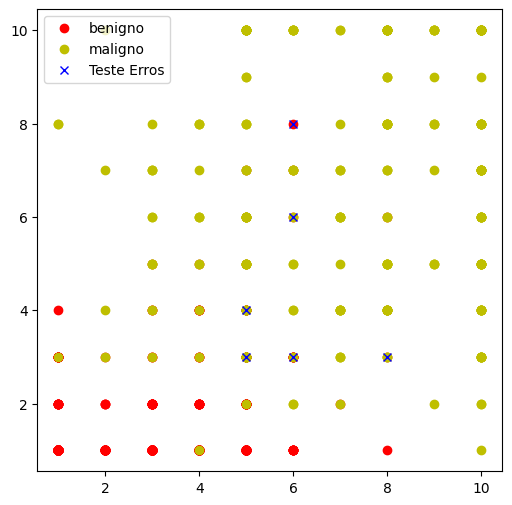

In [ ]:
#voltando os tensores para a cpu
rigth_wrong_ans = rigth_wrong_ans.cpu()

#Visualizando os dados incorretos no gráfico de pontos
plt.figure(figsize=(6,6))
plt.plot(benigno[:,0],benigno[:,2],'or',label='benigno')
plt.plot(maligno[:,0],maligno[:,2],'yo',label='maligno')

plt.plot(X_test[rigth_wrong_ans==False,0],X_test[rigth_wrong_ans==False,2],'xb',label='Teste Erros')
plt.legend()
plt.show()

#Voltando o modelo para a CPU

In [ ]:
device = torch.device("cpu")
model = model.to(device)

## Aplicar as métricas de Precision, Recall, F1-Score e mostrar a matriz de confusão


*   [classification report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
*   [confusion matrix](https://www.scikit-yb.org/en/latest/api/classifier/confusion_matrix.html)



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
with torch.no_grad():

  #voltar tensor para cpu
  X_testT = X_testT.cpu()
  y_pred = y_pred.cpu()
  y_testT = y_testT.cpu()

  y_pred = model(X_testT)
  # Fazer previsões

  #tratar resultado das predições
  y_pred = (y_pred >= 0.5).float()
  list_pred = []
  for i in range(len(y_pred)):
    if y_pred[i][0] > y_pred[i][1]:
     list_pred.append(0)
    else:
      list_pred.append(1)

  y_pred = torch.Tensor(list_pred)
  y_pred = y_pred.to(torch.int)

  # Calcular as métricas de precisão

  precision = precision_score(y_testT, y_pred)
  recall = recall_score(y_testT, y_pred)
  f1 = f1_score(y_testT, y_pred)

  print("Precision:", precision)
  print("Recall:", recall)
  print("F1-score:", f1)


Precision: 0.8723404255319149
Recall: 1.0
F1-score: 0.9318181818181819


Matriz de confusão


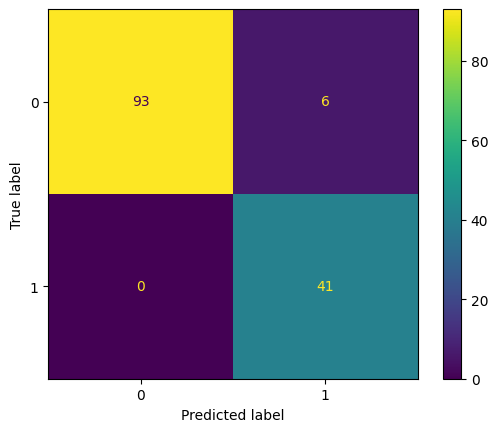

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred)).plot()
plt.grid(False)
plt.show()